<a href="https://colab.research.google.com/github/coda-nsit/kaggle/blob/Titanic/Kaggle_Titanic_LogisticClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p /root/.kaggle
!mv kaggle.json /root/.kaggle
!kaggle competitions download -c titanic

  0% 0.00/3.18k [00:00<?, ?B/s]
100% 3.18k/3.18k [00:00<00:00, 7.95MB/s]
  0% 0.00/28.0k [00:00<?, ?B/s]
100% 28.0k/28.0k [00:00<00:00, 22.9MB/s]
  0% 0.00/59.8k [00:00<?, ?B/s]
100% 59.8k/59.8k [00:00<00:00, 52.8MB/s]


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import  DataLoader, Dataset, RandomSampler, SequentialSampler
from torch.optim import Adam
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score
import torch

from tqdm import tqdm

# Load the data

In [3]:
data = pd.read_csv("train.csv")
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Preprocessing Data

In [0]:
def preprocess_data(filename):
  data = pd.read_csv(filename)
  passenger_ids = data.loc[:, "PassengerId"]
  data = data.drop(columns=["Name", "PassengerId", "Cabin"], axis=1)
  
  # categorize the category columns
  data['Embarked'] = data['Embarked'].astype('category')
  data['Sex'] = data['Sex'].astype('category')
  data['Ticket'] = data['Ticket'].astype('category')
  category_columns = data.select_dtypes(['category']).columns
  data[category_columns] = data[category_columns].apply(lambda x: x.cat.codes)

  # fill age with median age
  data["Age"] = data["Age"].fillna(data["Age"].median())
  
  return data, passenger_ids

In [5]:
data, _ = preprocess_data("train.csv")
data.shape

(891, 9)

In [6]:
X, y = data.drop(columns=["Survived"]), data["Survived"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=np.random)
print(X_train.shape)
print(y.shape)

(623, 8)
(891,)


In [0]:
class Passengers(Dataset):
  def __init__(self, passengers):
    self.data = passengers
  
  def __getitem__(self, index):
    r = self.data.iloc[index]
    label = torch.tensor(r["Survived"], dtype=torch.long)         # label is of type long
    sample = torch.tensor(r.drop(labels=["Survived"]), dtype=torch.float32)
    return sample, label

  def __len__(self):
    return len(self.data)

In [0]:
class LogisticClassifier(torch.nn.Module):
  def __init__(self, input_size, num_classes):
      super(LogisticClassifier, self).__init__()
      self.node = nn.Linear(input_size, num_classes)

  def forward(self, x):
      outputs = self.node(x)
      return outputs

In [9]:
train_data = pd.concat([X_train, y_train], axis=1)
train_dataset = Passengers(train_data)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_dataset, batch_size=200, sampler=train_sampler)

val_data = pd.concat([X_val, y_val], axis=1)
print(val_data.shape)
val_dataset = Passengers(val_data)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_dataset, sampler=val_sampler)

(268, 9)




epoch:   0%|          | 0/500 [00:00<?, ?it/s]

LogisticClassifier(
  (node): Linear(in_features=8, out_features=2, bias=True)
)




epoch:   0%|          | 1/500 [00:01<08:30,  1.02s/it]

epoch:   0%|          | 2/500 [00:02<08:23,  1.01s/it]

epoch:   1%|          | 3/500 [00:03<08:20,  1.01s/it]

epoch:   1%|          | 4/500 [00:03<08:16,  1.00s/it]

epoch:   1%|          | 5/500 [00:04<08:14,  1.00it/s]

epoch:   1%|          | 6/500 [00:06<08:16,  1.01s/it]

epoch:   1%|▏         | 7/500 [00:07<08:15,  1.01s/it]

epoch:   2%|▏         | 8/500 [00:08<08:12,  1.00s/it]

epoch:   2%|▏         | 9/500 [00:09<08:10,  1.00it/s]

epoch:   2%|▏         | 10/500 [00:10<08:12,  1.00s/it]

epoch:   2%|▏         | 11/500 [00:11<08:15,  1.01s/it]

epoch:   2%|▏         | 12/500 [00:12<08:06,  1.00it/s]

epoch:   3%|▎         | 13/500 [00:13<08:04,  1.00it/s]

epoch:   3%|▎         | 14/500 [00:14<08:06,  1.00s/it]

epoch:   3%|▎         | 15/500 [00:14<08:02,  1.00it/s]

epoch:   3%|▎         | 16/500 [00:16<08:03,  1.00it/s]

epoch:   3%|▎         | 17/500 [00:16<08:00,  1.01it/s]

epoch:   4%|▎         | 18/500 [00:17<

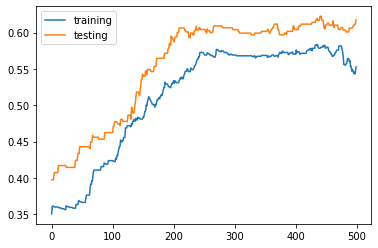

In [25]:
model = LogisticClassifier(8, 2)
model.cuda()
optimizer = Adam(model.parameters(), lr=0.0001)
epochs = 500
device = torch.device("cuda")

print(model)

f1s_training = []
f1s_testing = []

for epoch in tqdm(range(epochs), desc="epoch"):
  
  # training
  total_loss, total_correct = 0, 0

  complete_train_predictions = []
  complete_train_labels = []
  for batch_idx, batch in enumerate(train_dataloader):
  # for batch_idx, batch in enumerate(tqdm(train_dataloader, desc="batch")):
    model.train()
    
    batch = tuple(t.to(device) for t in batch)
    passengers, labels = batch
    
    # get the predictions
    logits = model(passengers)
    complete_train_predictions.extend(np.argmax(logits.detach().cpu().numpy(), axis=1))
    complete_train_labels.extend(labels.detach().cpu().numpy())

    # get the loss
    loss = F.cross_entropy(logits, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss
    total_correct += logits.argmax(dim=1).eq(labels).sum().item()
  f1 = f1_score(complete_train_labels, complete_train_predictions)
  f1s_training.append(f1)
  
  # validation
  complete_test_predictions = []
  complete_test_labels = []
  for idx, row in enumerate(val_dataloader):
    model.eval()
    row = tuple(t.to(device) for t in row)
    
    with torch.no_grad():
      passenger, label = row
      # get the predictions
      logit = model(passenger)
      prediction = np.argmax(logit.detach().cpu().numpy(), axis=1)

    complete_test_predictions.extend(prediction)
    complete_test_labels.extend(label.detach().cpu().numpy())
  f1 = f1_score(complete_test_predictions, complete_test_labels)
  f1s_testing.append(f1)

plt.plot([i for i in range(epochs)], f1s_training, label="training")
plt.plot([i for i in range(epochs)], f1s_testing, label="testing")
plt.legend(loc="upper left")
plt.show()

In [26]:
print("loss", total_loss)

loss tensor(5.7084, device='cuda:0', grad_fn=<AddBackward0>)


# Test Dataset

In [0]:
class PassengersTest(Dataset):
  def __init__(self, passengers):
    self.data = passengers
  
  def __getitem__(self, index):
    r = self.data.iloc[index]
    sample = torch.tensor(r, dtype=torch.float32)
    return sample

  def __len__(self):
    return len(self.data)

In [28]:
test_data, passenger_ids = preprocess_data("test.csv")
display("before setting value of Fare", test_data[test_data.isnull().any(axis=1)])
test_data.loc[152, "Fare"] = 0
display("after setting the value of Fare", test_data[test_data.isnull().any(axis=1)])

test_dataset = PassengersTest(test_data)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler)

complete_test_predictions = []
for idx, row in enumerate(test_dataloader):
  model.eval()
  passenger = row.to(device)
  
  with torch.no_grad():
    # get the predictions
    logit = model(passenger)
    prediction = np.argmax(logit.detach().cpu().numpy(), axis=1)
  complete_test_predictions.extend(prediction)

'before setting value of Fare'

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
152,3,1,60.5,0,0,239,NaN,2


'after setting the value of Fare'

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked


In [0]:
output = pd.DataFrame.from_records([(passenger_id, prediction) for passenger_id, prediction in zip(passenger_ids, complete_test_predictions)], 
                                   columns=["PassengerId", "Survived"])
output.to_csv("output.csv", index=None)